In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
from common.utils.pickling import pickle_read, pickle_write
from common.utils.misc import *
import matplotlib.pyplot as plt
import networkx as nx
from prepare_submission_data import pkl_to_tar
import re
from collections import defaultdict
import random
from sklearn.neighbors import NearestNeighbors


#### load oracle loss

In [3]:
# load oracle loss
p_oracle_val_loss = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/trained_oracle_models/6.44/losses_27-6.44/val_sample_loss_27-6.44.csv'
ora_loss = load_sample_loss_csv(p_oracle_val_loss).sort_values('loss', ascending=False)
ora_loss['spath'] = ora_loss.path.str.replace('/mnt/ext/shared/Projects/GNNetworkingChallenge/validation_dataset_pkl/','')
ora_loss.iloc[0].spath

'170/results_400-2000_5_5_s_0.pkl'

#### load val stats

In [4]:
# load val stats
path = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/validation_dataset/sample_stats_val.csv'
val = pd.read_csv(path)
val=val.rename(columns={val.columns[0]: 'spath'})
val['path'] = '/mnt/ext/shared/Projects/GNNetworkingChallenge/validation_dataset_pkl/' + val.spath.str[2:]
val = pd.merge(ora_loss, val.drop('spath', axis=1), on='path')
print('unique datasets: ', val.dset.unique())
val.head()

unique datasets:  ['170' '240' '200' '130' '280' '100' '300' '75' '50' '260']


,path,loss,flows,net_size,wloss,dset,spath,LinkLoads_count,LinkLoads_mean,LinkLoads_std,...,AvgDelay_mean,AvgDelay_std,AvgDelay_min,AvgDelay_10%,AvgDelay_25%,AvgDelay_50%,AvgDelay_70%,AvgDelay_80%,AvgDelay_90%,AvgDelay_max
0,/mnt/ext/shared/Projects/GNNetworkingChallenge...,23.864992,28730,170,0.143498,170,170/results_400-2000_5_5_s_0.pkl,368.0,1.662027,0.382000,...,0.079334,0.107321,0.001019,0.012901,0.022980,0.041631,0.068605,0.103911,0.179093,0.98187
1,/mnt/ext/shared/Projects/GNNetworkingChallenge...,22.858261,28730,170,0.137445,170,170/results_400-2000_8_8_s_0.pkl,368.0,1.594005,0.375664,...,0.075805,0.105450,0.000934,0.012468,0.021464,0.037375,0.061471,0.094833,0.186805,1.21533
2,/mnt/ext/shared/Projects/GNNetworkingChallenge...,21.996872,57360,240,0.264071,240,240/results_400-2000_29_29_s_0.pkl,486.0,1.545393,0.449241,...,0.057326,0.091150,0.000536,0.006213,0.009713,0.020331,0.049827,0.080603,0.156023,1.13566
3,/mnt/ext/shared/Projects/GNNetworkingChallenge...,21.312956,39800,200,0.177532,200,200/results_400-2000_7_7_s_0.pkl,426.0,1.542006,0.436834,...,0.071533,0.100754,0.000977,0.007338,0.014021,0.030023,0.065107,0.102910,0.202910,0.92949
4,/mnt/ext/shared/Projects/GNNetworkingChallenge...,20.793732,39800,200,0.173207,200,200/results_400-2000_29_29_s_0.pkl,416.0,1.615281,0.447635,...,0.080519,0.111001,0.000530,0.007559,0.014160,0.033854,0.077272,0.130815,0.218548,1.18231


#### load train stats

In [5]:
stat_files = ['/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/generated_datasets/sample_stats_all1-15-hard1.csv',
              '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/generated_datasets/sample_stats_hard2.csv',
              '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/generated_datasets/sample_stats_hard3.csv',
              '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/generated_datasets/sample_stats_hard4.csv',
              '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/generated_datasets/sample_stats_hard5.csv',
              '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/generated_datasets/sample_stats_hard5_small.csv',
              '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/generated_datasets/sample_stats_hard5_small2.csv',
              '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/generated_datasets/sample_stats_hard5_small3.csv',
              '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/generated_datasets/sample_stats_hard5_small4.csv',
             ]
df = pd.concat([pd.read_csv(p) for p in stat_files])

In [6]:
df=df.rename(columns={df.columns[0]: 'spath'})
df['spath'] = df.spath.str[2:]
df['path'] = '/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/' + df.spath
df['dset'] = df.path.str.split('/').str[7]
print('unique datasets: ', df.dset.unique())
gp = df.groupby('dset')
df.head()


unique datasets:  ['11' '14' '8' '5' '10' '12' '0' '2' '3' '13' '6' '7' 'hard1' '9' '1'
 'hard2' '15' '4' 'hard3' 'hard4' 'hard5' 'hard5_small' 'hard5_small2'
 'hard5_small3' 'hard5_small4']


,spath,LinkLoads_count,LinkLoads_mean,LinkLoads_std,LinkLoads_min,LinkLoads_10%,LinkLoads_25%,LinkLoads_50%,LinkLoads_70%,LinkLoads_80%,...,AvgDelay_min,AvgDelay_10%,AvgDelay_25%,AvgDelay_50%,AvgDelay_70%,AvgDelay_80%,AvgDelay_90%,AvgDelay_max,path,dset
0,11/2022-09-19__16-04-20__byval_rndpath_bylengt...,18.0,0.931106,0.347506,0.515185,0.586510,0.701941,0.823616,1.109905,1.205565,...,0.040466,0.178374,0.262034,0.312599,0.393606,0.555477,0.703239,1.03770,/mnt/ext/shared/Projects/GNNetworkingChallenge...,11
1,11/2022-09-19__16-04-20__byval_rndpath_bylengt...,16.0,0.765584,0.334010,0.059239,0.493967,0.549003,0.741897,0.940716,0.972810,...,0.035556,0.135473,0.182572,0.245897,0.320298,0.381389,2.951317,3.11043,/mnt/ext/shared/Projects/GNNetworkingChallenge...,11
2,11/2022-09-19__16-04-20__byval_rndpath_bylengt...,16.0,1.176211,0.494361,0.060331,0.808949,0.902080,1.125279,1.324582,1.488915,...,0.041688,0.162494,0.259448,0.365706,2.878047,4.151954,4.900988,8.80154,/mnt/ext/shared/Projects/GNNetworkingChallenge...,11
3,11/2022-09-19__16-04-20__byval_rndpath_bylengt...,16.0,1.005862,0.500289,0.063843,0.612377,0.669002,0.849059,1.213749,1.578577,...,0.048142,0.128263,0.244007,0.338341,0.829137,1.005917,1.825543,2.81372,/mnt/ext/shared/Projects/GNNetworkingChallenge...,11
4,11/2022-09-19__16-04-20__byval_rndpath_bylengt...,16.0,0.905058,0.443482,0.055300,0.535784,0.613405,0.892735,0.997633,1.049451,...,0.046818,0.136549,0.194842,0.271715,0.346386,0.431759,5.743002,5.96610,/mnt/ext/shared/Projects/GNNetworkingChallenge...,11


In [7]:
df.columns

Index(['spath', 'LinkLoads_count', 'LinkLoads_mean', 'LinkLoads_std',
       'LinkLoads_min', 'LinkLoads_10%', 'LinkLoads_25%', 'LinkLoads_50%',
       'LinkLoads_70%', 'LinkLoads_80%', 'LinkLoads_90%', 'LinkLoads_max',
       'PktsDrop_count', 'PktsDrop_mean', 'PktsDrop_std', 'PktsDrop_min',
       'PktsDrop_10%', 'PktsDrop_25%', 'PktsDrop_50%', 'PktsDrop_70%',
       'PktsDrop_80%', 'PktsDrop_90%', 'PktsDrop_max', 'AvgDelay_count',
       'AvgDelay_mean', 'AvgDelay_std', 'AvgDelay_min', 'AvgDelay_10%',
       'AvgDelay_25%', 'AvgDelay_50%', 'AvgDelay_70%', 'AvgDelay_80%',
       'AvgDelay_90%', 'AvgDelay_max', 'path', 'dset'],
      dtype='object')

#### find similar train samples

In [8]:
df.groupby('dset')['AvgDelay_50%'].describe()

,count,mean,std,min,25%,50%,75%,max
dset,,,,,,,,
0,9714.0,0.092014,0.261796,0.005045,0.015449,0.022561,0.042839,2.068945
1,19370.0,0.173894,0.519638,0.005391,0.018133,0.027910,0.058183,9.717080
10,10456.0,0.237813,0.198852,0.046108,0.149801,0.205450,0.271834,6.383745
11,10446.0,0.433078,0.435088,0.067991,0.259601,0.333223,0.436267,7.110955
12,10331.0,2.744165,1.986682,0.111533,1.386742,2.356790,3.560342,23.435900
13,10348.0,2.793110,2.050837,0.121786,1.413386,2.369347,3.540770,26.110200
14,10343.0,1.355206,1.444750,0.055946,0.357182,0.829872,1.844092,14.814050
15,10350.0,0.576169,1.001228,0.057901,0.170997,0.259515,0.465238,14.315950
2,11769.0,0.117822,0.533914,0.005861,0.013746,0.019334,0.035513,9.958860


In [9]:
linkcols = ['LinkLoads_min', 'LinkLoads_10%', 'LinkLoads_25%', 'LinkLoads_50%',
            'LinkLoads_70%', 'LinkLoads_80%', 'LinkLoads_90%', 'LinkLoads_max']
dropcols = ['PktsDrop_min', 'PktsDrop_10%', 'PktsDrop_25%', 'PktsDrop_50%', 'PktsDrop_70%',
            'PktsDrop_80%', 'PktsDrop_90%', 'PktsDrop_max']
delaycols = ['AvgDelay_min', 'AvgDelay_10%',
             'AvgDelay_25%', 'AvgDelay_50%', 'AvgDelay_70%', 'AvgDelay_80%',
             'AvgDelay_90%', 'AvgDelay_max']
allcols = ['LinkLoads_mean', 'LinkLoads_std',
       'LinkLoads_min', 'LinkLoads_10%', 'LinkLoads_25%', 'LinkLoads_50%',
       'LinkLoads_70%', 'LinkLoads_80%', 'LinkLoads_90%', 'LinkLoads_max',
       'PktsDrop_mean', 'PktsDrop_std', # 'PktsDrop_min',
       'PktsDrop_10%', 'PktsDrop_25%', 'PktsDrop_50%', 'PktsDrop_70%',
       'PktsDrop_80%', 'PktsDrop_90%', 'PktsDrop_max', 
       'AvgDelay_mean', 'AvgDelay_std', 'AvgDelay_min', 'AvgDelay_10%',
       'AvgDelay_25%', 'AvgDelay_50%', 'AvgDelay_70%', 'AvgDelay_80%',
       'AvgDelay_90%', 'AvgDelay_max',]

colmap = {'link': linkcols, 'drop': dropcols, 'delay': delaycols, 'all': allcols}

def get_nns(val, tr, sortkey, ccols, ntop, k, norm):
    top = val.sort_values(by=sortkey, ascending=False).iloc[:ntop]

    valfeat = top[ccols]
    trfeat = tr[ccols]

    if norm:
        mean, std = trfeat.mean(), trfeat.std()
        valfeat = (valfeat - mean) / std
        trfeat = (trfeat - mean) / std

    # find nearest neighbors using selected features
    nn = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(trfeat.values)
    dnn, inn = nn.kneighbors(valfeat.values)
    nns = tr.iloc[np.unique(inn)]
    print(len(nns), 'unique samples')
    print('nns by dataset:')
    print(nns.dset.value_counts())
    return dnn, inn, nns

#### Experiment 1

(before hard5)

In [27]:
sets = [ {'sortkey': 'loss', 'stats': 'all', 'ntop': 30, 'k': 15, 'norm': True},
    {'sortkey': 'loss', 'stats': 'link', 'ntop': 30, 'k': 10, 'norm': False},
 {'sortkey': 'loss', 'stats': 'drop', 'ntop': 30, 'k': 10, 'norm': False},
 {'sortkey': 'loss', 'stats': 'delay', 'ntop': 30, 'k': 10, 'norm': False},
 {'sortkey': 'loss', 'stats': 'link+drop', 'ntop': 30, 'k': 10, 'norm': True},
 {'sortkey': 'loss', 'stats': 'all', 'ntop': 30, 'k': 15, 'norm': False},
]

In [10]:
save_root = Path('/mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/stat_nn')

In [32]:
ntries = 63
for ii, iset in enumerate(sets):
    iset_root = save_root / f"{ii:02d}_by_{iset['sortkey']}_{iset['stats']}_ntop_{iset['ntop']}_k_{iset['k']}_norm_{iset['norm']}"
    if not iset_root.exists():
        iset_root.mkdir()

    cols = []
    for c in iset['stats'].split('+'):
        cols.extend(colmap[c])

    _, _, nns = get_nns(val, df, sortkey=iset['sortkey'], ccols=cols, ntop=iset['ntop'], k=iset['k'], norm=iset['norm'])
    for i in range(ntries):
        inns = nns.sample(100)
        save_list(inns, iset_root / f'{i:02d}')
    

185 unique samples
nns by dataset:
hard3    51
hard4    51
14       36
11       15
8        13
10        6
12        3
13        3
7         3
15        2
6         1
9         1
Name: dset, dtype: int64
245 unique samples
nns by dataset:
hard3    106
hard4     52
14        39
11        25
8          6
13         5
12         4
hard2      4
10         2
hard1      1
15         1
Name: dset, dtype: int64
298 unique samples
nns by dataset:
hard4    66
11       53
hard3    51
15       34
10       29
8        20
hard2    14
hard1    13
14        4
5         3
6         3
1         3
9         2
0         1
2         1
13        1
Name: dset, dtype: int64
291 unique samples
nns by dataset:
5        91
1        76
2        34
6        24
0        22
4        21
3        14
9         4
7         2
15        2
hard3     1
Name: dset, dtype: int64
223 unique samples
nns by dataset:
hard3    94
hard4    49
11       37
14       13
hard2    11
8        10
15        4
10        3
13        1
hard1 

#### results

In [108]:
p_root = Path('/mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/stat_nn')
paths = list(p_root.glob('**/modelCheckpoints'))
print(len(paths), 'paths found')

378 paths found


In [120]:
results = []
for p in paths:
    exp = p.relative_to(p_root).parts[0]
    subexp = p.relative_to(p_root).parts[1]
    resfile = p.parent / 'val_eval.log'
    if not resfile.exists():
        continue
    iresult = pd.read_csv(resfile).set_index('epoch')
    best = iresult.loc[iresult.loss.idxmin()]
    results.append({'path': str(p.parent),
                    'exp': exp,
                    'subexp': subexp,
                    'loss': best.loss,
                    'ckpt': best.ckpt,
                   })

results = pd.DataFrame(results).sort_values('loss')
results.head()

,path,exp,subexp,loss,ckpt
341,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,00_by_loss_all_ntop_30_k_15_norm_True,30,7.5392,16-10.64
92,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,05_by_loss_all_ntop_30_k_15_norm_False,12,7.6137,17-6.87
250,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,02_by_loss_drop_ntop_30_k_10_norm_False,19,7.6780,15-9.96
356,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,00_by_loss_all_ntop_30_k_15_norm_True,35,7.7613,10-7.59
192,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,02_by_loss_drop_ntop_30_k_10_norm_False,11,7.8108,13-15.73


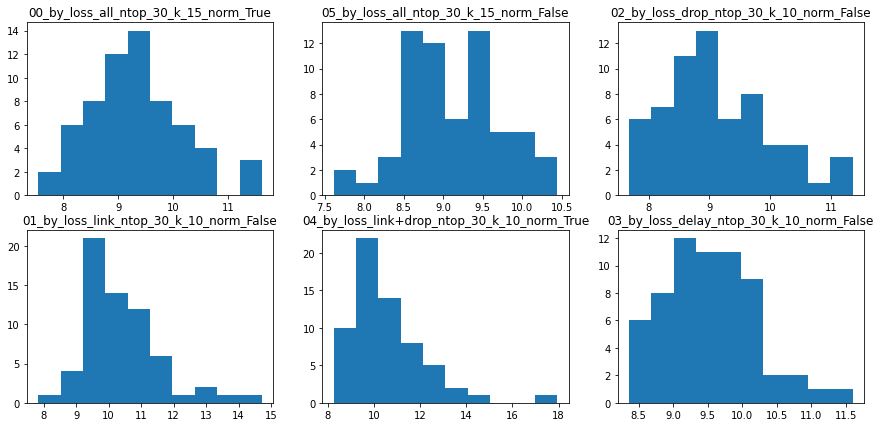

In [123]:
f, axx = plt.subplots(2,3, figsize=(15,7))
axx = np.concatenate((axx[0], axx[1]))
for i, exp in enumerate(results.exp.unique()):
    plt.sca(axx[i])
    plt.hist(results[results.exp == exp].loss)
    plt.title(exp)
    

#### Experiment 2

take a good set and replace some of its samples with nns from hard5

##### load good set and identify hard/easy samples 

In [10]:
# load 6.675 set
p_sample_loss = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/submissions/4/n_3_0_2022-10-12__09-56-16/eval/train_sample_loss_07-12.58.csv'
smp_loss = load_sample_loss_csv(p_sample_loss)
smp_loss.head()

,path,loss,flows,net_size,wloss,dset
0,/mnt/ext/shared/Projects/GNNetworkingChallenge...,16.220457,90,10,0.187399,hard3
1,/mnt/ext/shared/Projects/GNNetworkingChallenge...,20.112219,90,10,0.232362,hard3
2,/mnt/ext/shared/Projects/GNNetworkingChallenge...,12.958881,72,9,0.119774,hard4
3,/mnt/ext/shared/Projects/GNNetworkingChallenge...,10.237164,90,10,0.118273,hard4
4,/mnt/ext/shared/Projects/GNNetworkingChallenge...,4.494335,56,8,0.032308,15


<AxesSubplot:>

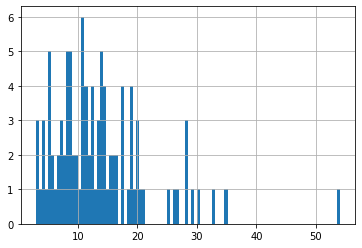

In [11]:
smp_loss.loss.hist(bins=100)

In [12]:
gp = {
    'hardest': smp_loss[smp_loss.loss>23],
    'hard': smp_loss[(smp_loss.loss>10) & (smp_loss.loss<=23)],
    'medium': smp_loss[(smp_loss.loss>5) & (smp_loss.loss<=10)],
    'easiest': smp_loss[smp_loss.loss<=5],
}
for k, v in gp.items():
    print(k, v.shape)


hardest (11, 6)
hard (52, 6)
medium (29, 6)
easiest (8, 6)


##### define pool of nearest neighbor samples to use as replacement
here we use only hard5 set

In [13]:
_, _, nns = get_nns(val, df[df.dset == 'hard5'], sortkey='loss', ccols=allcols, ntop=30, k=15, norm=False)

202 unique samples
nns by dataset:
hard5    202
Name: dset, dtype: int64


In [15]:
save_root = Path('/mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/stat_nn2_hard5_from_6.675')
#save_root.mkdir()

##### random swaps

In [23]:
# random splice
ntries = 10
for nswap in [1, 2, 4, 8]:
    for i in range(ntries):       
        rm = smp_loss.sample(nswap)
        add = nns.sample(nswap)
        new100 = splice_and_shuffle(smp_loss, rm=rm, add=add)

        isave_root = save_root / f'random_{nswap}' / f'{i:02d}'
        if not isave_root.exists():
            isave_root.mkdir(parents=True)
        save_list(new100, isave_root)


##### replace hardest

In [31]:
# replace hardest with their friends
ntries = 10

hardest = gp['hardest']
for nswap in [1, 2, 4, 6]:
    for i in range(ntries):
        rm = hardest.sample(nswap)
        add = nns.sample(nswap)
        new100 = splice_and_shuffle(smp_loss, rm=rm, add=add)

        isave_root = save_root / f'repl_hardest_{nswap}' / f'{i:02d}'
        if not isave_root.exists():
            isave_root.mkdir(parents=True)
        save_list(new100, isave_root)


In [84]:
val[val.net_size==50].sort_values(by='loss', ascending=False)

,path,loss,flows,net_size,wloss,dset,spath,LinkLoads_count,LinkLoads_mean,LinkLoads_std,...,AvgDelay_mean,AvgDelay_std,AvgDelay_min,AvgDelay_10%,AvgDelay_25%,AvgDelay_50%,AvgDelay_70%,AvgDelay_80%,AvgDelay_90%,AvgDelay_max
16,/mnt/ext/shared/Projects/GNNetworkingChallenge...,15.806831,2450,50,0.008105,50,50/results_400-2000_11_11_s_0.pkl,114.0,1.331898,0.433068,...,0.237986,0.865343,0.003997,0.024177,0.040051,0.069338,0.129280,0.259690,0.622140,26.218300
19,/mnt/ext/shared/Projects/GNNetworkingChallenge...,14.784934,2450,50,0.007581,50,50/results_400-2000_33_33_s_0.pkl,114.0,1.390841,0.425434,...,0.193036,0.359858,0.004690,0.025240,0.040043,0.069645,0.123572,0.193651,0.558750,3.012560
26,/mnt/ext/shared/Projects/GNNetworkingChallenge...,12.409439,2450,50,0.006363,50,50/results_400-2000_36_36_s_0.pkl,114.0,1.312735,0.391119,...,0.129853,0.226479,0.004324,0.024131,0.038085,0.060934,0.092838,0.141366,0.275851,2.431910
30,/mnt/ext/shared/Projects/GNNetworkingChallenge...,8.625037,2450,50,0.004423,50,50/results_400-2000_40_40_s_0.pkl,114.0,1.200480,0.372124,...,0.131474,0.319122,0.004539,0.021466,0.034251,0.052118,0.076499,0.099578,0.268146,4.906930
59,/mnt/ext/shared/Projects/GNNetworkingChallenge...,5.264339,2450,50,0.002699,50,50/results_400-2000_43_43_s_0.pkl,114.0,0.953463,0.324729,...,0.091231,0.421968,0.003975,0.019111,0.029431,0.041894,0.052918,0.062477,0.080918,6.386640
63,/mnt/ext/shared/Projects/GNNetworkingChallenge...,4.904465,2450,50,0.002515,50,50/results_400-2000_18_18_s_0.pkl,114.0,0.936782,0.269368,...,0.052611,0.064588,0.003854,0.019131,0.028973,0.040839,0.052053,0.061219,0.076128,0.945015
65,/mnt/ext/shared/Projects/GNNetworkingChallenge...,4.712881,2450,50,0.002417,50,50/results_400-2000_12_12_s_0.pkl,114.0,0.942521,0.309760,...,0.066526,0.146313,0.003762,0.019154,0.028765,0.041830,0.054869,0.065653,0.088652,1.436470
66,/mnt/ext/shared/Projects/GNNetworkingChallenge...,4.677932,2450,50,0.002399,50,50/results_400-2000_37_37_s_0.pkl,114.0,0.938381,0.296559,...,0.055724,0.083429,0.003710,0.019065,0.029097,0.041624,0.054103,0.064193,0.085248,2.377090
102,/mnt/ext/shared/Projects/GNNetworkingChallenge...,2.306268,2450,50,0.001183,50,50/results_400-2000_28_28_s_0.pkl,114.0,0.627649,0.192917,...,0.037749,0.021931,0.003493,0.016654,0.024883,0.034047,0.042711,0.049734,0.061722,0.325051
104,/mnt/ext/shared/Projects/GNNetworkingChallenge...,2.248834,2450,50,0.001153,50,50/results_400-2000_3_3_s_0.pkl,114.0,0.627649,0.192778,...,0.037769,0.022172,0.003532,0.016718,0.024930,0.034113,0.042660,0.049772,0.061022,0.344202


In [106]:
linkcols = ['LinkLoads_min', 'LinkLoads_10%', 'LinkLoads_25%', 'LinkLoads_50%',
            'LinkLoads_70%', 'LinkLoads_80%', 'LinkLoads_90%', 'LinkLoads_max']
dropcols = ['PktsDrop_min', 'PktsDrop_10%', 'PktsDrop_25%', 'PktsDrop_50%', 'PktsDrop_70%',
            'PktsDrop_80%', 'PktsDrop_90%', 'PktsDrop_max']
delaycols = ['AvgDelay_min', 'AvgDelay_10%',
             'AvgDelay_25%', 'AvgDelay_50%', 'AvgDelay_70%', 'AvgDelay_80%',
             'AvgDelay_90%', 'AvgDelay_max']
allcols = ['LinkLoads_mean', 'LinkLoads_std',
       'LinkLoads_min', 'LinkLoads_10%', 'LinkLoads_25%', 'LinkLoads_50%',
       'LinkLoads_70%', 'LinkLoads_80%', 'LinkLoads_90%', 'LinkLoads_max',
       'PktsDrop_mean', 'PktsDrop_std', 'PktsDrop_min',
       'PktsDrop_10%', 'PktsDrop_25%', 'PktsDrop_50%', 'PktsDrop_70%',
       'PktsDrop_80%', 'PktsDrop_90%', 'PktsDrop_max', 
       'AvgDelay_mean', 'AvgDelay_std', 'AvgDelay_min', 'AvgDelay_10%',
       'AvgDelay_25%', 'AvgDelay_50%', 'AvgDelay_70%', 'AvgDelay_80%',
       'AvgDelay_90%', 'AvgDelay_max',]

sortkey = 'loss'
ntop = 30
norm = False
ccols = allcols # linkcols # allcols
k = 15

top = val.sort_values(by=sortkey, ascending=False).iloc[:ntop]

valfeat = top[ccols]
trfeat = df[ccols]

if norm:
    mean, std = trfeat.mean(), trfeat.std()
    valfeat = (valfeat - mean) / std
    trfeat = (trfeat - mean) / std

# find nearest neighbors using selected features
nn = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(trfeat.values)
dnn, inn = nn.kneighbors(valfeat.values)
nns = df.iloc[np.unique(inn)]
print(len(nns), 'unique samples')
print('nns by dataset:')
print(nns.dset.value_counts())

246 unique samples
nns by dataset:
hard5           82
hard3           49
14              35
hard4           26
1               13
12               7
11               5
5                4
15               3
8                3
10               3
6                3
4                3
hard5_small4     2
13               2
2                2
hard1            1
0                1
hard5_small      1
7                1
Name: dset, dtype: int64


In [49]:
pd.concat((top.iloc[0:1], df.iloc[inn[0,:3]])).T

,0,27922,9829,7946
path,/mnt/ext/shared/Projects/GNNetworkingChallenge...,/mnt/ext/shared/Projects/GNNetworkingChallenge...,/mnt/ext/shared/Projects/GNNetworkingChallenge...,/mnt/ext/shared/Projects/GNNetworkingChallenge...
loss,23.864992,NaN,NaN,NaN
flows,28730.0,NaN,NaN,NaN
net_size,170.0,NaN,NaN,NaN
wloss,0.143498,NaN,NaN,NaN
dset,170,8,hard4,11
spath,170/results_400-2000_5_5_s_0.pkl,8/2022-09-17__12-57-23__byval_route_random_net...,hard4/2022-10-04__23-03-23__hard3_lbw_25k-40k_...,11/2022-09-19__16-04-20__byval_rndpath_bylengt...
LinkLoads_count,368.0,8.0,11.0,9.0
LinkLoads_mean,1.662027,1.535786,1.531024,1.589605
LinkLoads_std,0.382,0.484773,0.485389,0.544661


In [94]:
df.iloc[27922].spath

'8/2022-09-17__12-57-23__byval_route_random_netsz_9_35x10_p01-04_12/results/2022-09-17__12-57-23__byval_route_random_netsz_9_35x10_p01-04_12/results_2022-09-17__12-57-23__byval_route_random_netsz_9_35x10_p01-04_12_254_254_s_0.pkl'

In [46]:
df[df.dset=='hard4'][linkcols]

,LinkLoads_min,LinkLoads_10%,LinkLoads_25%,LinkLoads_50%,LinkLoads_70%,LinkLoads_80%,LinkLoads_90%,LinkLoads_max
0,0.096914,0.409811,0.603527,0.794889,0.995952,1.094716,1.592762,3.925143
1,0.569473,0.630559,0.672946,0.785586,1.204904,1.857915,2.750763,3.207570
2,0.540401,0.618205,0.659704,0.948527,1.290324,1.997147,2.968586,3.279014
3,0.416339,0.462236,0.655350,0.857800,1.371346,2.164390,2.448710,3.722056
4,0.659114,0.731991,0.788389,0.901801,1.307862,1.755677,2.550732,3.420851
...,...,...,...,...,...,...,...,...
17886,0.053615,0.169068,0.534384,0.774046,1.032620,1.164221,1.268221,1.781831
17887,0.096081,0.119810,0.573684,0.817421,1.101549,1.301604,1.422776,1.623343
17888,0.088203,0.137265,0.492211,0.731537,0.990998,1.114636,1.228781,1.495138
17889,0.077684,0.141201,0.462967,0.822709,0.926537,1.126446,1.232460,1.422658


In [45]:
ff = ['/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/hard4/2022-10-04__22-56-22__hard3_lbw_25k-40k_like8_easier1_bsz_uniform_avgbw_large_1_netsz_9_10x10_p_0.3_0/results/2022-10-04__22-56-22__hard3_lbw_25k-40k_like8_easier1_bsz_uniform_avgbw_large_1_netsz_9_10x10_p_0.3_0/results_2022-10-04__22-56-22__hard3_lbw_25k-40k_like8_easier1_bsz_uniform_avgbw_large_1_netsz_9_10x10_p_0.3_0_85_85_s_0.pkl', '/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/hard3/2022-10-04__00-06-08__hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_2_netsz_9_10x10_p_0.3_3/results/2022-10-04__00-06-08__hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_2_netsz_9_10x10_p_0.3_3/results_2022-10-04__00-06-08__hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_2_netsz_9_10x10_p_0.3_3_38_38_s_0.pkl', '/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/hard3/2022-10-03__23-49-58__hard3_lbw_from_traffic-above_bsz_small_2_avgbw_large_2_netsz_10_100x1_p_0.3_21/results/2022-10-03__23-49-58__hard3_lbw_from_traffic-above_bsz_small_2_avgbw_large_2_netsz_10_100x1_p_0.3_21/results_2022-10-03__23-49-58__hard3_lbw_from_traffic-above_bsz_small_2_avgbw_large_2_netsz_10_100x1_p_0.3_21_10_10_s_0.pkl', '/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/hard3/2022-10-04__00-15-31__hard3_lbw_25k-40k_like8_bsz_small_2_avgbw_large_2_netsz_10_10x10_p_0.3_9/results/2022-10-04__00-15-31__hard3_lbw_25k-40k_like8_bsz_small_2_avgbw_large_2_netsz_10_10x10_p_0.3_9/results_2022-10-04__00-15-31__hard3_lbw_25k-40k_like8_bsz_small_2_avgbw_large_2_netsz_10_10x10_p_0.3_9_38_38_s_0.pkl', '/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/hard3/2022-10-04__00-06-08__hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_2_netsz_9_10x10_p_0.3_3/results/2022-10-04__00-06-08__hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_2_netsz_9_10x10_p_0.3_3/results_2022-10-04__00-06-08__hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_2_netsz_9_10x10_p_0.3_3_96_96_s_0.pkl', '/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/hard3/2022-10-04__00-05-04__hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_1_netsz_9_10x10_p_0.3_0/results/2022-10-04__00-05-04__hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_1_netsz_9_10x10_p_0.3_0/results_2022-10-04__00-05-04__hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_1_netsz_9_10x10_p_0.3_0_3_3_s_0.pkl', '/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/7/2022-09-17__12-52-24__byval_route_by_linkbw_netsz_10_35x10_p01-04_7/results/2022-09-17__12-52-24__byval_route_by_linkbw_netsz_10_35x10_p01-04_7/results_2022-09-17__12-52-24__byval_route_by_linkbw_netsz_10_35x10_p01-04_7_307_307_s_0.pkl', '/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/hard3/2022-10-04__00-14-31__hard3_lbw_25k-40k_like8_bsz_small_2_avgbw_large_1_netsz_10_10x10_p_0.3_6/results/2022-10-04__00-14-31__hard3_lbw_25k-40k_like8_bsz_small_2_avgbw_large_1_netsz_10_10x10_p_0.3_6/results_2022-10-04__00-14-31__hard3_lbw_25k-40k_like8_bsz_small_2_avgbw_large_1_netsz_10_10x10_p_0.3_6_31_31_s_0.pkl', '/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/11/2022-09-19__16-04-20__byval_rndpath_bylength_netsz_10_35x10_p01-04_28/results/2022-09-19__16-04-20__byval_rndpath_bylength_netsz_10_35x10_p01-04_28/results_2022-09-19__16-04-20__byval_rndpath_bylength_netsz_10_35x10_p01-04_28_60_60_s_0.pkl', '/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/15/2022-09-27__13-26-37__config_asval_rndpath3_netsz_9_35x10_p01-04_11/results/2022-09-27__13-26-37__config_asval_rndpath3_netsz_9_35x10_p01-04_11/results_2022-09-27__13-26-37__config_asval_rndpath3_netsz_9_35x10_p01-04_11_70_70_s_0.pkl']
df[df.path.isin(ff)][delaycols]
df[df.path.isin(ff)].dset

4134         11
138497        7
177487       15
8524      hard3
12264     hard3
14548     hard3
14612     hard3
15008     hard3
16726     hard3
14399     hard4
Name: dset, dtype: object

In [58]:
[f.replace('/mnt/ext/shared/Projects/GNNetworkingChallenge/generated_datasets_pkl/', '').split('/')[1][len('2022-10-04__22-56-22__'):] for f in ff]

['hard3_lbw_25k-40k_like8_easier1_bsz_uniform_avgbw_large_1_netsz_9_10x10_p_0.3_0',
 'hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_2_netsz_9_10x10_p_0.3_3',
 'hard3_lbw_from_traffic-above_bsz_small_2_avgbw_large_2_netsz_10_100x1_p_0.3_21',
 'hard3_lbw_25k-40k_like8_bsz_small_2_avgbw_large_2_netsz_10_10x10_p_0.3_9',
 'hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_2_netsz_9_10x10_p_0.3_3',
 'hard3_lbw_10k-25k_1_bsz_small_2_avgbw_large_1_netsz_9_10x10_p_0.3_0',
 'byval_route_by_linkbw_netsz_10_35x10_p01-04_7',
 'hard3_lbw_25k-40k_like8_bsz_small_2_avgbw_large_1_netsz_10_10x10_p_0.3_6',
 'byval_rndpath_bylength_netsz_10_35x10_p01-04_28',
 'config_asval_rndpath3_netsz_9_35x10_p01-04_11']